<a href="https://www.kaggle.com/code/minhthonglai/ielts-llm-tuner?scriptVersionId=242752328" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# LLM Fine-tuning for Essay Scoring

- Download lastest output: [ielts-LLM-tuner's output](https://www.kaggle.com/api/v1/kernels/output/download/minhthonglai/ielts-llm-tuner)

## Global Setting Variables

In [1]:
MODEL_ID = "EleutherAI/gpt-j-6B" # Using GPT-J
MODEL_PATH = 'models/'
LOAD_MODEL_PATH = 'models/pretrained_gpt2'
COMPRESSED_MODEL_PATH = 'compressed_models/'
DATA_PATH = 'data/'
RANDOM_SEED = 42 # Set to `None` for the generator uses the current system time.
LOAD_MODEL = True
TRAIN_MODEL = True
SAVE_MODEL = True
TARGET_MODULES = ["q_proj", "v_proj"],  # GPT-J attention layers

## System configurations 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when create a version using "Save & Run All" 
# Can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import sys
import os

# Check Python version
print(f"Python Version: `{sys.version}`")  # Detailed version info
print(f"Base Python location: `{sys.base_prefix}`")
print(f"Current Environment location: `{os.path.basename(sys.prefix)}`", end='\n\n')

/kaggle/input/ielts-writing-tasks/generate_synthetic_data.txt
/kaggle/input/ielts-writing-tasks/synthetic_data_.json
/kaggle/input/ielts-writing-tasks/synthetic_data.json
Python Version: `3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]`
Base Python location: `/usr`
Current Environment location: `usr`



In [3]:
import torch
import time  # for CPU timing

# Check if GPU is available and being used
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name()}")
    print(f"Device memory: {torch.cuda.get_device_properties(0).total_memory / 1e9} GB")

# This code will work in both CPU and GPU environments
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
    
# Test with a simple operation - modified to work on both CPU and GPU
x = torch.rand(10000, 10000, device=device)
y = torch.rand(10000, 10000, device=device)

if device.type == "cuda":
    # GPU timing approach
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    z = x @ y  # Matrix multiplication
    end.record()
    torch.cuda.synchronize()
    print(f"Operation time: {start.elapsed_time(end)} ms")
else:
    # CPU timing approach
    start_time = time.time()
    z = x @ y  # Matrix multiplication
    end_time = time.time()
    print(f"Operation time: {(end_time - start_time) * 1000} ms")

CUDA available: False
Using device: cpu
Operation time: 17273.57578277588 ms


## Install required libraries

In [4]:
# %pip install transformers peft datasets accelerate bitsandbytes trl
# %pip install sentencepiece

## Import Libraries and Set Configuration

In [5]:
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel
from datasets import Dataset, load_dataset

import os
import re
import time
import json
import shutil
from IPython.display import FileLinks, FileLink
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

np.random.seed(RANDOM_SEED)

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available. Setting up GPU environment...")
    # Set maximum GPU memory usage to avoid OOM errors
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    torch.cuda.empty_cache()
else:
    print("No GPU detected. Running in CPU-only mode.")
    # Ensure CUDA is disabled
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Enable memory efficient attention - works for both CPU and GPU
os.environ["TRANSFORMERS_OFFLINE"] = "1"  # Work offline if model is downloaded

2025-05-30 14:55:45.603693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748616945.941734      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748616946.085393      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


No GPU detected. Running in CPU-only mode.


## Prepare the IELTS Dataset

In [6]:
# Save `dict()` into `.json` files
def saveJSON(data, json_path="data.json"):
    os.makedirs(os.path.dirname(json_path), exist_ok=True) # Create folder if does not exist 
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

# Load `.json` files
def loadJSON(json_path='data.json'):
    with open(json_path) as f:
        data = json.load(f)
    return data

### Sample code to create a dataset for IELTS assessment


Need to prepare the dataset with this structure:

```
Data format structure:

data = {
  "input": [
    """Rate this IELTS essay:

Topic: [topic essay text]

Essay: [student essay text]""", ...
    ],

  "output": [
    """Task Achievement: [band score] - [detailed feedback]

Coherence and Cohesion: [band score] - [detailed feedback]

Lexical Resource: [band score] - [detailed feedback]

Grammatical Range and Accuracy: [band score] - [detailed feedback]

Overall Band Score: [band score]""", ...
    ]
}
```

In [7]:
data = loadJSON("/kaggle/input/ielts-writing-tasks/synthetic_data.json")

In [8]:
SYNTHETIC_DATA_PATH = os.path.join(DATA_PATH, f"synthetic_data.json")
saveJSON(data, SYNTHETIC_DATA_PATH)

In [9]:
# Load comprehensive data for IELTS assessment across different levels

SYNTHETIC_DATA_PATH = os.path.join(DATA_PATH, f"synthetic_data.json")
data = loadJSON(SYNTHETIC_DATA_PATH)

# Create dataset from your dictionary
dataset = Dataset.from_dict(data)
print(f"Dataset created with {len(dataset)} entries")

Dataset created with 20 entries


### Split dataset

In [10]:
# Use train_test_split for cleaner splitting
split_dataset = dataset.train_test_split(test_size=0.1, seed=RANDOM_SEED)

train_dataset = split_dataset['train'] # 90% for training
test_dataset = split_dataset['test'] # 10% for testing

print(f"Training entries: {len(train_dataset)}")
print(f"Testing entries: {len(test_dataset)}")

Training entries: 18
Testing entries: 2


### Band Score Distribution in the dataset

In [11]:
def plot_band_score_distribution(dataset, title="IELTS Band Score Distribution"):
    """
    Plot distribution of IELTS band scores.
    
    Parameters:
    dataset (Dataset): A Hugging Face Dataset containing IELTS assessments
    """
    
    # 1) Extract & clean scores
    pattern = re.compile(r"Overall Band Score: (\d+\.?\d*)")
    scores = [
        float(m.group(1))
        for ex in dataset
        if (m := pattern.search(ex["output"]))
    ]
    band_scores = np.asarray(scores, float)
    band_scores = band_scores[np.isfinite(band_scores)]
    if band_scores.size == 0:
        print("No valid band scores found.")
        return

    # 2) Histogram bins & KDE
    bins = np.arange(4.5, 9.5, 0.5)
    density, edges = np.histogram(band_scores, bins=bins, density=True)
    kde = gaussian_kde(band_scores)
    x_kde = np.linspace(edges[0], edges[-1], 200)

    # 3) Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(edges[:-1], density, width=np.diff(edges), color="skyblue", edgecolor="white", alpha=0.8)

    # Density curve
    ax.plot(x_kde, kde(x_kde), color="blue", linewidth=2, alpha=0.3)

    # Add mean line
    mean_score = band_scores.mean()
    ax.axvline(mean_score, color="tomato", linestyle="--", linewidth=1.5)
    plt.text(mean_score+0.1, plt.ylim()[1]*0.9, f'Mean: {mean_score:.2f}', fontsize=10, color='tomato')

    # Add total of essays context
    plt.figtext(0.02, 0.02, f"n={len(band_scores)} essays", ha="left", va="bottom", fontsize=10, alpha=0.7)

    # 4) Style
    ax.set_title(title, fontsize=14, fontweight="bold", pad=12)
    ax.set_xlabel("Band Score", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.set_xticks(bins)
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()

    # 5) Summary
    print(
        f"Mean: {band_scores.mean():.2f} | "
        f"Median: {np.median(band_scores):.2f} | "
        f"Range: {band_scores.min():.1f}–{band_scores.max():.1f} | "
        f"N={band_scores.size}"
    )

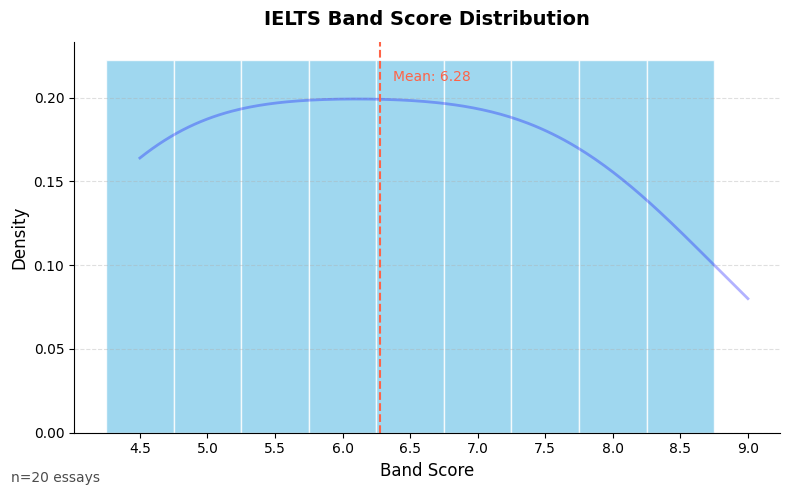

Mean: 6.28 | Median: 6.25 | Range: 4.0–9.0 | N=20


In [12]:
plot_band_score_distribution(dataset)

## Load model with Quantization for Memory Efficiency

In [13]:
# Define quantization configuration
if torch.cuda.is_available():
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
    )
else:
    None

if LOAD_MODEL and os.path.exists(LOAD_MODEL_PATH):
    # Load the base model WITH appropriate quantization
    if torch.cuda.is_available():
        model = AutoModelForCausalLM.from_pretrained(
            MODEL_ID,
            quantization_config=quantization_config, # GPU: Use 4-bit quantization 
            torch_dtype=torch.float16,
            device_map="auto"
        )
    else:
        # CPU: Use memory-efficient loading
        cpu_model_id = "distilgpt2"  # Only 82M parameters vs 6B
        model = AutoModelForCausalLM.from_pretrained(
            cpu_model_id,
            low_cpu_mem_usage=True,
            device_map="auto"
        )
    
    print(f"Load tokenizer from {LOAD_MODEL_PATH}...")
    tokenizer = AutoTokenizer.from_pretrained(LOAD_MODEL_PATH)
    tokenizer.pad_token = tokenizer.eos_token  # Re-set padding token
else:    
    # Check if GPU is available
    if torch.cuda.is_available():
        print("GPU detected! Using 4-bit quantization...")
        # Load with quantization for GPU
        model = AutoModelForCausalLM.from_pretrained(
            MODEL_ID,
            quantization_config=quantization_config, # GPU: Use 4-bit quantization
            torch_dtype=torch.float16,
            device_map="auto"
        )
    else:
        print("No GPU detected! For development, using a smaller model instead...")
        # For CPU development, consider using a much smaller model
        # Most LLM are too large for most CPU environments
        cpu_model_id = "distilgpt2"  # Only 82M parameters vs 6B
        model = AutoModelForCausalLM.from_pretrained(
            cpu_model_id,
            low_cpu_mem_usage=True,
            device_map="auto"
        )
        print(f"⚠️ NOTE: Using {cpu_model_id} instead of {MODEL_ID} for CPU development!")
        print("⚠️ Remember to switch to GPU when ready for actual fine-tuning")
    
    # Get the tokenizer for whatever model we loaded
    tokenizer = AutoTokenizer.from_pretrained(MODEL_ID if torch.cuda.is_available() else cpu_model_id)
    tokenizer.pad_token = tokenizer.eos_token  # Set padding token

No GPU detected! For development, using a smaller model instead...


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

⚠️ NOTE: Using distilgpt2 instead of EleutherAI/gpt-j-6B for CPU development!
⚠️ Remember to switch to GPU when ready for actual fine-tuning


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## Configure LoRA for Parameter-Efficient Fine-Tuning

In [14]:
if LOAD_MODEL and os.path.exists(LOAD_MODEL_PATH):
    print(f"Load LoRA adapters from {LOAD_MODEL_PATH}...")
    model = PeftModel.from_pretrained(model, LOAD_MODEL_PATH, is_trainable=TRAIN_MODEL)
else:
    target_modules = TARGET_MODULES if torch.cuda.is_available() else ["c_attn", "c_proj", "c_fc", "lm_head"]
    
    # For GPT-J style models:
    peft_config = LoraConfig(
        r=8,                     # Rank dimension
        lora_alpha=32,           # Alpha parameter for LoRA scaling
        lora_dropout=0.1,        # Dropout probability for LoRA layers
        bias="none",
        task_type="CAUSAL_LM",
        target_modules = target_modules
    )
    
    # Apply LoRA to model
    model = get_peft_model(model, peft_config)

# Print configuration
print(f"Current model: `{model.config.model_type}` from `{model.config._name_or_path}`")
print(f"Using target modules for `{model.config.model_type}` style architecture: {model.peft_config['default'].target_modules}")

# Print trainable parameters to verify setup
model.print_trainable_parameters()


# Check more detailed information
print("\nModel details:")
print(f"Architecture: {model.__class__.__name__}")
if hasattr(model, 'config'):
    print(f"Hidden size: {model.config.hidden_size}")
    print(f"Vocabulary size: {model.config.vocab_size}")
    print(f"Number of parameters: {(sum(p.numel() for p in model.parameters())/1000000):.2f}M")
    print(f"Model's maximum token length: {model.config.max_position_embeddings}")

Current model: `gpt2` from `distilgpt2`
Using target modules for `gpt2` style architecture: {'lm_head', 'c_proj', 'c_attn', 'c_fc'}
trainable params: 998,024 || all params: 82,910,600 || trainable%: 1.2037

Model details:
Architecture: PeftModelForCausalLM
Hidden size: 768
Vocabulary size: 50257
Number of parameters: 82.91M
Model's maximum token length: 1024


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1264: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1255: UserWarning: fan_in_fan_out is set to True but the target module is `torch.nn.Linear`. Setting fan_in_fan_out to False.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:543: UserWarning: Model with `tie_word_embeddings=True` and the tied_target_modules=['lm_head'] are part of the adapter. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. See for example https://github.com/huggingface/peft/issues/2018.
  warnings.warn(


## Define Training Arguments

In [15]:

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=1,   # Keep small due to memory constraints
    gradient_accumulation_steps=4,   # Accumulate gradients to simulate larger batch
    save_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True if torch.cuda.is_available() else False, # Use mixed precision
    report_to="none",                # Disable wandb reporting
    optim="adamw_torch",
    max_grad_norm=0.3,               # Gradient clipping
    warmup_ratio=0.03,               # Warmup for learning rate
)

## Set Up Trainer

In [16]:
# class IELTSDataCollator:
#     def __init__(self, tokenizer):
#         self.tokenizer = tokenizer
        
#     def __call__(self, entries):
#         # Extract input and output
#         inputs = [entry["input"] for entry in entries]
#         outputs = [entry["output"] for entry in entries]
        
#         # Format the text (input followed by output)
#         texts = [f"<|user|>\n{inp}\n<|assistant|>\n{out}</s>" for inp, out in zip(inputs, outputs)]
        
#         # Tokenize
#         batch = self.tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
        
#         # For causal language modeling, use the input_ids as labels too
#         batch["labels"] = batch["input_ids"].clone()
        
#         return batch

# # Create the custom data collator
# data_collator = IELTSDataCollator(tokenizer)


In [17]:
def preprocess_function(entries):
    # Format the text
    texts = [
        f"<|user|>\n{entries['input'][i]}\n<|assistant|>\n{entries['output'][i]}</s>"
        for i in range(len(entries['input']))
    ]
    
    # Tokenize
    tokenized = tokenizer(texts, padding="max_length", truncation=True, max_length=512)
    
    # For language modeling
    tokenized["labels"] = tokenized["input_ids"].copy()
    
    return tokenized

# Process the dataset
processed_dataset = train_dataset.map(
    preprocess_function, 
    batched=True,
    remove_columns=train_dataset.column_names  # Remove the original columns
)

# Define the Trainer with processed dataset
trainer = Trainer(
    model=model,
    args=training_args,  # No need for remove_unused_columns=False here
    train_dataset=processed_dataset,
    data_collator=DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False),
)

Map:   0%|          | 0/18 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


## Start Fine-Tuning

In [18]:
if TRAIN_MODEL:
    # Start training
    trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


In [19]:
# # Data collator
# data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# # Define custom data formatting function
# def formatting_func(entries):
#     texts = []
#     for i in range(len(entries["input"])):
#         text = f"<|user|>\n{entries['input'][i]}\n<|assistant|>\n{entries['output'][i]}</s>"
#         texts.append(text)
#     return texts

# # Define the Trainer
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     tokenizer=tokenizer,
#     data_collator=data_collator,
# )

# # Start training
# trainer.train()

## Save the Fine-Tuned Model

In [20]:
if SAVE_MODEL:
    CURRENT_MODEL_PATH = os.path.join(MODEL_PATH, f"pretrained_{model.config.model_type}")
    
    # Save the model (just the LoRA weights, not the full model)
    model.save_pretrained(CURRENT_MODEL_PATH)
    tokenizer.save_pretrained(CURRENT_MODEL_PATH)
    
    # Download the model to the local machine
    display(FileLinks(CURRENT_MODEL_PATH))

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:230: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


models/pretrained_gpt2/
  merges.txt
  special_tokens_map.json
  tokenizer.json
  tokenizer_config.json
  adapter_config.json
  README.md
  adapter_model.safetensors
  vocab.json

### Zip into a file
For downloading in case running on online platform like Kaggle

In [21]:
if SAVE_MODEL:
    CURRENT_COMPRESSED_MODEL_PATH = os.path.join(COMPRESSED_MODEL_PATH, f"pretrained_{model.config.model_type}")
    
    # Create the directory if it doesn't exist
    os.makedirs(COMPRESSED_MODEL_PATH, exist_ok=True)
    
    # Create zip file (method 1: using Python's shutil)
    shutil.make_archive(
        CURRENT_COMPRESSED_MODEL_PATH,
        'zip',
        os.path.dirname(CURRENT_MODEL_PATH),
        os.path.basename(CURRENT_MODEL_PATH),
    )
    
    # Alternative for Jupyter/Colab environments (method 2)
    # !zip -r {CURRENT_COMPRESSED_MODEL_PATH}.zip {CURRENT_MODEL_PATH}
    
    # Create download link in Jupyter/Colab
    display(FileLink(f"{CURRENT_COMPRESSED_MODEL_PATH}.zip"))

/kaggle/working/compressed_models/pretrained_gpt2.zip

## Test the Fine-Tuned Model

In [22]:
def evaluate_essay(essay_text, verbose=False):
    """Evaluate a single essay with proper formatting and display"""

    global inputs, output
    
    # Tokenize with proper settings
    inputs = tokenizer(
        essay_text, 
        return_tensors="pt", 
        # padding=True,
        # truncation=True,
        # max_length=1024  # Set appropriate length
    ).to(device)
    
    # Generate assessment
    start_time = time.time()
    output = model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=300,  # Adjust based on expected assessment length
        # min_new_tokens=150,
        do_sample=True,  # Add this line to enable sampling
        temperature=0.7,
        top_p=0.9,
        repetition_penalty=1.2,
        pad_token_id=tokenizer.pad_token_id
    )
    end_time = time.time()
    
    # Get only the generated part
    input_length = inputs["input_ids"].shape[1]
    generated_ids = output[0][input_length:]
    output_length = len(generated_ids)
    generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
    
    # Display results
    if verbose:
        print("\n====== METADATA ======")
        print(f"Essay length: [{len(essay_text)}] characters")
        print(f"Input tokens: [{input_length}] tokens")
        print(f"Output tokens: [{output_length}] tokens")
        print(f"Generation took: [{end_time - start_time:.2f}] seconds")
        
        # print("====== GENERATED ASSESSMENT ======")
        # print(generated_text)
    
    return generated_text

# Function to evaluate multiple entries from a dataset
def evaluate_dataset(dataset, verbose=False):
    """Evaluate multiple entries from a dataset"""
    results = []

    num_entries = len(dataset)

    if verbose == False:
        # Create progress bar object
        tqdm._instances.clear()
        pbar = tqdm(range(num_entries), desc="Evaluating Essays")
                      
    for i in range(num_entries):
        if verbose:
            print(f"\n\n===== EVALUATING ESSAY [{i+1}/{num_entries}] =====")
        else:
            pbar.set_description(f"Evaluating Essay... [{i+1}/{num_entries}]")

        # Extract full essay text
        essay_text = dataset[i]['input']
        expected_output = dataset[i]['output']
        
        # Evaluate
        generated_assessment = evaluate_essay(essay_text, verbose)

        if verbose == False:
            pbar.update(1)
        
        # Store results
        results.append({
            "entry_id": i,
            "generated": generated_assessment,
            "expected": expected_output
        })

    return results

In [23]:
# Get the test input
test_input = train_dataset['input']

print(test_input[0])

Rate this IELTS essay:

Topic: Some people think that it is better to educate boys and girls in separate schools. Others, however, believe that boys and girls benefit more from attending mixed schools. Discuss both these views and give your own opinion.

Essay:
School for boy and girl. Some school only boy, some only girl. Some school boy and girl together. Which is good?

Some people say separate school is better. Boy can focus on study. Girl can focus on study. No distraction. Teacher can teach different for boy and girl. Because boy and girl learn different. This is one idea.

Other people say mixed school is better. Boy and girl learn to work together. This is important for life. In job, man and woman work together. So school must be same. They learn social skill. Understand each other.

My opinion, I think mixed school is good. Because real world is boy and girl together. So school should teach this. But separate school maybe good for some children. If they are shy. But mostly mix

In [24]:
# Run evaluation on the test dataset
results = evaluate_dataset(test_dataset)

Evaluating Essay... [2/2]: 100%|██████████| 2/2 [00:07<00:00,  3.73s/it]


### Decoded Output Results

In [25]:
# Generated Assessments

print("====== GENERATED ASSESSMENT ======")
for result in results:
    print(f"\nEntry ID: {result['entry_id']}")
    print(result['generated'])

====== GENERATED ASSESSMENT ======

Entry ID: 0
As noted above—the Internet needs broad attention on how we connect our lives through communications networks which allow us all to participate together; sharing technologies where tools work efficiently without requiring government intervention (see "How To Find Your Data") should be considered when addressing technical security concerns affecting consumers' ability to act responsibly within circumstances. Moreover, there remains room for effective national action around encryption systems across Europe via mobile devices/Internet service providers because they provide reasonable protections under European Union law relating to users' rights regarding sensitive activity related to third parties like Skype and other messaging apps.

Entry ID: 1
Notes


In [26]:
results

[{'entry_id': 0,
  'generated': 'As noted above—the Internet needs broad attention on how we connect our lives through communications networks which allow us all to participate together; sharing technologies where tools work efficiently without requiring government intervention (see "How To Find Your Data") should be considered when addressing technical security concerns affecting consumers\' ability to act responsibly within circumstances. Moreover, there remains room for effective national action around encryption systems across Europe via mobile devices/Internet service providers because they provide reasonable protections under European Union law relating to users\' rights regarding sensitive activity related to third parties like Skype and other messaging apps.',
  'expected': 'Task Achievement: 8.0 - Sufficiently addresses all parts of the task. Presents a well-developed and clear position in response to the question, with relevant, extended, and well-supported ideas. The argumen